## Data Loading
First leg of the journey (10,000 points)

In [1]:
import pandas as pd

telemetry = pd.read_csv('./telemetry_cleaned.csv')

# X = telemetry[['Easting', 'Northing', 'WaterDepth']].head(10619) # 10,000
X = telemetry[['Easting', 'Northing', 'WaterDepth']].head(10619) # 1,000
# X = X[X['WaterDepth'] >= 30]
# X = X[X['WaterDepth'] <= 65]

### Plot Helpers

In [2]:
import matplotlib.pyplot as plt

def plot2d(data):
	data.plot(kind='scatter', x='Easting', y='Northing')

def plot3d(data, title):
	fig = plt.figure()
	ax = fig.add_subplot(projection='3d')
	ax.scatter(data['Easting'], data['Northing'], data['WaterDepth'])
	ax.set_xlabel('Easting')
	ax.set_ylabel('Northing')
	ax.set_label
	ax.set_zlabel('WaterDepth')
	ax.set_title(title)
	plt.show()

### Pre-Clustering Plots

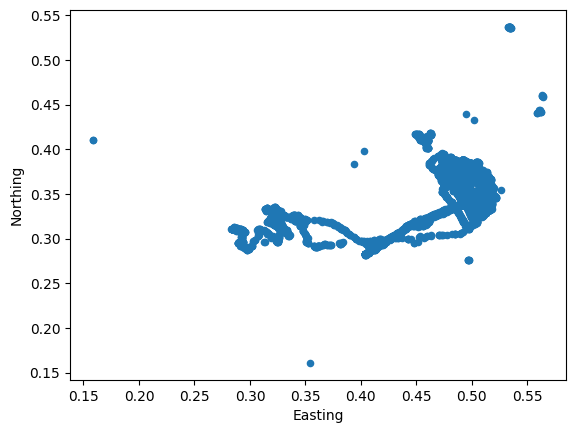

In [3]:
plot2d(X)

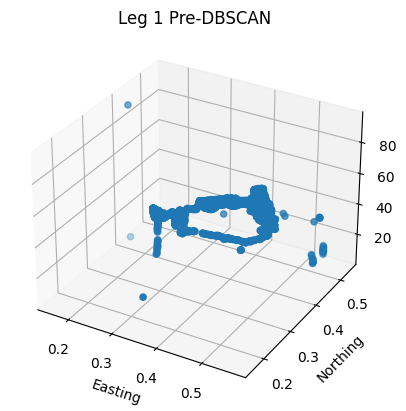

In [4]:
plot3d(X, 'Leg 1 Pre-DBSCAN')

## DBSCAN Clustering
Using eps=0.3 and min_samples=10

In [5]:
from sklearn.cluster import DBSCAN
from sklearn import metrics

db = DBSCAN(eps=0.3, min_samples=10).fit(X)
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print(f'Estimated number of clusters: {n_clusters_}')
print(f'Estimated number of noise points: {n_noise_}')

Estimated number of clusters: 4
Estimated number of noise points: 105


## Cluster Evaluation Metrics
### Silhouette Coefficient
The silhouette coefficient measures the quality of the model by the distance significance between clusters.

It uses the following formula:
$$s = \frac{b-a}{\max{(a,b)}}$$

Where $a$ is the mean distance between a sample and all other points within the *same* cluster, and $b$ is the mean distance between a sample and all other points in the *next nearest* cluster. It outputs a score in the range of -1 to 1, where -1 indicated incorrect clustering and 1 indicates highly dense clustering. A score of 0 indicates an overlap in clusters.

Source: Adapted from [Quick Guide to Evaluation Metrics for Supervised and Unsupervised Machine Learning](https://www.analyticsvidhya.com/blog/2020/10/quick-guide-to-evaluation-metrics-for-supervised-and-unsupervised-machine-learning/) § Clustering Performance Evaluation Metrics

### Implementation
Scikit learn provides a silhouette_score method in its metrics module:

In [6]:
print(f'Silhouette Coefficient: {metrics.silhouette_score(X, labels):.3f}')

Silhouette Coefficient: 0.452


### Davies-Bouldin Score


### Dunn's Index
Another metric is Dunn's Index. The bigger the value of the resulting Dunn index, the better the clustering result is considered, since higher values indicate that clusters are compact (small :math:`diam(c_k)`) and far apart.
$$
D = \min_{i=1 \ldots n_c; j = i + 1\ldots n_c} \left\lbrace \frac{d(c_i,c_j)}{\max_{k = 1 \ldots n_c} (\text{diam}(c_k))}\right\rbrace
$$

Where
- $d(c_i,c_j)$ represents the distance between clusters. $c_i$ and $c_j$ are given by the distances between a sample's two closest points.
- $\text{diam}(c_k)$ is the diameter of the cluster, $c_k$ is given by the sample's two furthest points

[dunn-sklearn.py](https://gist.github.com/keizerzilla/a72056c0905e57a036e57b03b557c896#file-dunn-sklearn-py-L22)

In [8]:
# def dunn(labels, distances):
# 	labels = normalize_to_smallest_integers(labels)

# 	unique_cluster_distances = np.unique(min_cluster_distances(labels, distances))
# 	max_diameter = max(diameter(labels, distances))

# 	if np.size(unique_cluster_distances) > 1:
# 		return unique_cluster_distances[1] / max_diameter
# 	else:
# 		return unique_cluster_distances[0] / max_diametery

### Plots

In [8]:
import numpy as np

def plot_clusters(db, labels, clusters):
	unique_labels = set(labels)
	core_samples_mask = np.zeros_like(labels, dtype=bool)
	core_samples_mask[db.core_sample_indices_] = True

	colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]

	for k, color in zip(unique_labels, colors):
		if k == -1:
			# Black used for noise
			color = [0, 0, 0, 1]

		class_member_mask = labels == k

		core_samples = X[class_member_mask & core_samples_mask]

		plt.plot(
			core_samples['Easting'],
			core_samples['Northing'],
			"o",
			markerfacecolor=tuple(color),
			markeredgecolor='k',
			markersize=10,
		)

		non_core_samples = X[class_member_mask & ~core_samples_mask]
		plt.plot(
			non_core_samples['Easting'],
			non_core_samples['Northing'],
			"o",
			markerfacecolor=tuple(color),
			markeredgecolor='k',
			markersize=3,
		)

	plt.title(f'Estimated clusters: {clusters}')
	plt.show()

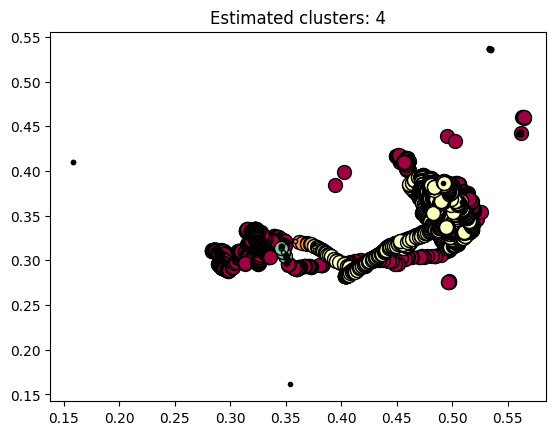

In [9]:
plot_clusters(db, labels, n_clusters_)

## Removing Clusters
First, let's map the labels to each row in the dataset.

In [15]:
X['label'] = labels
X.head(5)

,Easting,Northing,WaterDepth,label
0,0.158187,0.410159,92.93,-1
1,0.158187,0.410159,5.86,-1
2,0.534407,0.535898,5.86,-1
3,0.534311,0.535924,6.33,-1
4,0.533734,0.536254,7.02,-1


Then we can remove the rows labeled as noise, denoted by a value of -1.

In [18]:
denoised = X[X['label'] != -1]
denoised['label'].unique()

array([0, 3, 1, 2], dtype=int64)

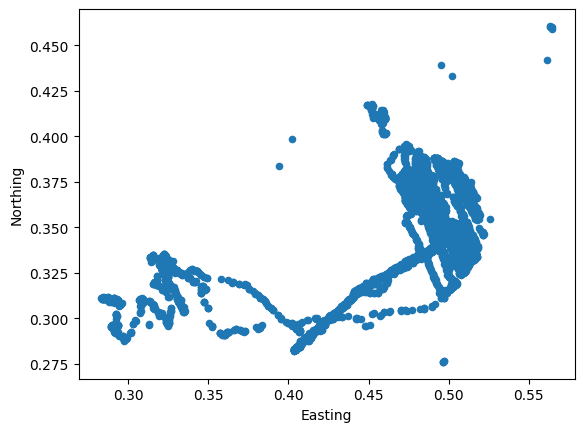

In [20]:
plot2d(denoised)